# Аналитика в Яндекс.Афише


Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. 
Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.
У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

### Описание данных 
Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

### План работы:
1. Загрузка данных и их подготовка к анализу
2. Расчет метрик и построение отчетов
    1. Изучение DAU, WAU, MAU
    - Изучение количества и длительности сессий
    - Изучение Retention Rate
    - Исследование когда клиенты начинают покупать и сколько раз покупают за период
    - Изучение средниего чека и прибыли с покупателя (LTV)
    - Исследование затрат на привлечение покупателей (всего/ на каждый источник / по времени)
    - Исследование затрат на привлечение через источники
    - Изучение окупаемости (ROI)
    - Исследование изменения метрик по источникам, устройствам и во времени
3. Рекомендация

## 1. Загрузим данные и подготовим их к анализу:

In [2]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
import plotly.io as pio
pio.renderers.default = "svg"

In [3]:
class color:
    header = '\033[95m'
    warning = '\033[93m'
    fail = '\033[91m'
    end = '\033[0m'
    bold = '\033[1m'
    underline = '\033[4m'

In [4]:
vis = 'visits.csv'
or_ = 'orders.csv'
co = 'costs.csv'

visits = pd.read_csv(vis)
orders = pd.read_csv(or_)
costs = pd.read_csv(co)

In [5]:
for i in [visits, orders, costs]:
    i.drop('Unnamed: 0', axis=1, inplace=True)
    
print(f'{color.bold}Лог сервера с данными о посещениях сайта Яндекс.Афиши:{color.end}')
display(visits.head())
print()
print(f'{color.bold}Выгрузка всех заказов за этот период:{color.end}')
display(orders.head())
print()
print(f'{color.bold}Cтатистика рекламных расходов:{color.end}')
display(costs.head())

Лог сервера с данными о посещениях сайта Яндекс.Афиши:


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168



Выгрузка всех заказов за этот период:


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450



Cтатистика рекламных расходов:


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Перед нами три датасета: логи сервера с данными о посещениях, выгрузка всех заказов за период и статистика рекламных расходов. Исследуем данные:

In [6]:
visits.info()
print()
orders.info()
print()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  

В данных нет пропусков, все столбцы с датами будем преобразовывать в datetime. Исследуем датасеты на наличие дубликатов:

In [7]:
print('Количество дубликатов в датасете visits:', visits.duplicated().sum())
print('Количество дубликатов в датасете orders:', orders.duplicated().sum())
print('Количество дубликатов в датасете costs:', costs.duplicated().sum())

Количество дубликатов в датасете visits: 0
Количество дубликатов в датасете orders: 0
Количество дубликатов в датасете costs: 0


Хорошие новости, в датасетах нет дубликатов. Приведем названия всех столбцов к нижнему регистру и переименуем столбцы, чтобы с ними было удобнее работать:

In [8]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
visits = visits.rename(columns={'end ts' : 'end_ts', 'source id' : 'source_id', 'start ts' : 'start_ts'})
orders = orders.rename(columns ={'buy ts' : 'buy_ts'})

Преобразуем все столбцы с датами к типу datetime:

In [9]:
for i in visits.columns:
    if i.endswith('ts'):
        visits[i] = pd.to_datetime(visits[i])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

### Вывод

Были получены три датасета: логи сервера с данными о посещениях, выгрузка всех заказов за период и статистика рекламных расходов. Данные исследованы на наличие пропусков и дубликатов, названия столбцов приведены к нижнему регистру, а столбцы с датами преобразованы к типу datetime.

## 2. Построение отчётов и расчет метрик

### Изучение DAU, WAU, MAU

Выделим из столбца start_ts датафрейма visits, день, номер недели и месяц:

In [10]:
visits['day'] = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].dt.week
visits['start_month_activity'] = visits['start_ts'].astype('datetime64[M]')

Построим график ежедневной активности и посчитаем ежедневное среднее число уникальных пользователей

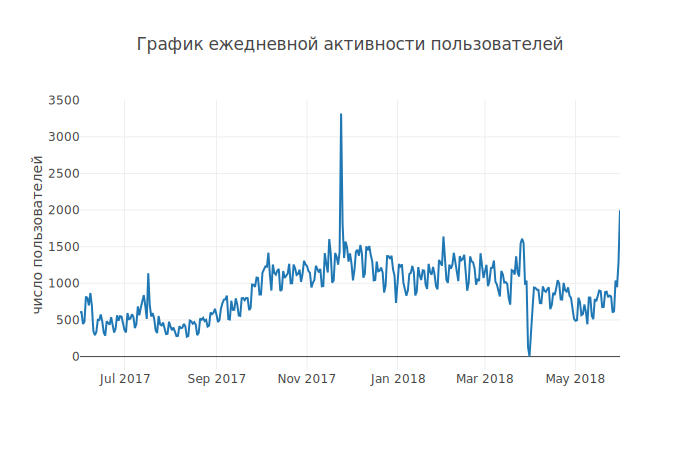

 Среднее число уникальных пользователей в день: 907


In [11]:
dau = visits.groupby('day').agg({'uid':'nunique'})
def plotly_line(x,y, title=None, mode='lines+markers', xtitle=None, ytitle=None):
    lineplot = go.Scatter(x=x,y=y, mode=mode)
    fig = go.Figure(data=lineplot)
    fig.update_layout(template=None, title={'text': title}, 
                      xaxis = {'title': xtitle}, 
                      yaxis = {'title': ytitle})
    fig.show()
    
plotly_line(dau.reset_index()['day'],dau.reset_index()['uid'],'График ежедневной активности пользователей', 
            mode='lines', ytitle='число пользователей')

print(f' Среднее число уникальных пользователей в день: {int(dau.mean())}')

Больше всего пользователей было 24 ноября 2017 года - 3319. Меньше всего 2018-03-31, только 1 пользователь - вероятно это могло быть связано с техническим сбоем сайта. Исследуем WAU:

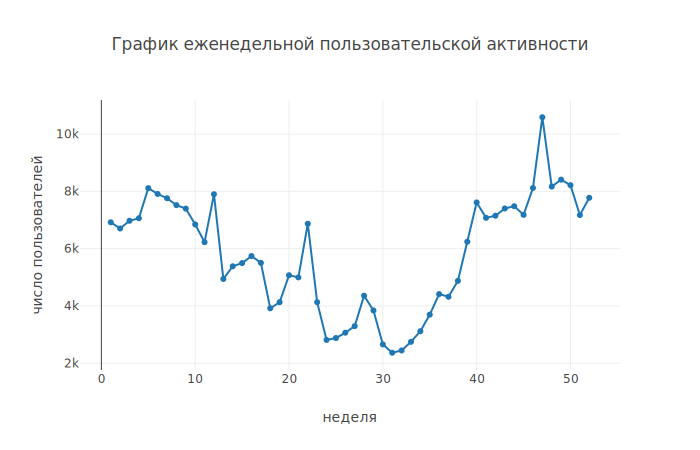

Среднее число уникальных пользователей в неделю: 5825


In [12]:
wau = visits.groupby('week').agg({'uid':'nunique'}).reset_index()
plotly_line(wau.reset_index()['week'],wau.reset_index()['uid'],'График еженедельной пользовательской активности',
           ytitle='число пользователей', xtitle='неделя')
print('Среднее число уникальных пользователей в неделю: {}'.format(int(wau['uid'].mean())))

На графике видно, что меньше всего пользователей в 31-ю неделю - 2364, а больше всего в 47-ю - 10586. Исследуем MAU:

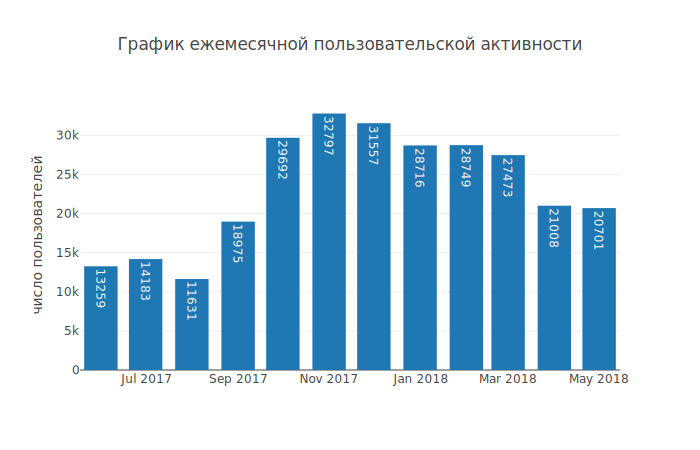

Среднее число уникальных пользователей в месяц: 23228


In [13]:
mau = visits.groupby('start_month_activity').agg({'uid':'nunique'}).reset_index()
barplot = go.Bar(x=mau.reset_index()['start_month_activity'], y=mau.reset_index()['uid'], 
                 text=mau.reset_index()['uid'], textposition='inside')
fig = go.Figure(barplot)
fig.update_layout(template=None, title={'text': 'График ежемесячной пользовательской активности'}, 
                  yaxis = {'title': 'число пользователей'})
fig.show()
print('Среднее число уникальных пользователей в месяц: {}'.format(int(mau['uid'].mean())))

Пик посещений пришелся на ноябрь 2017го, минимум на графике в августе 2017го.

### Изучение количества и длительности сессий

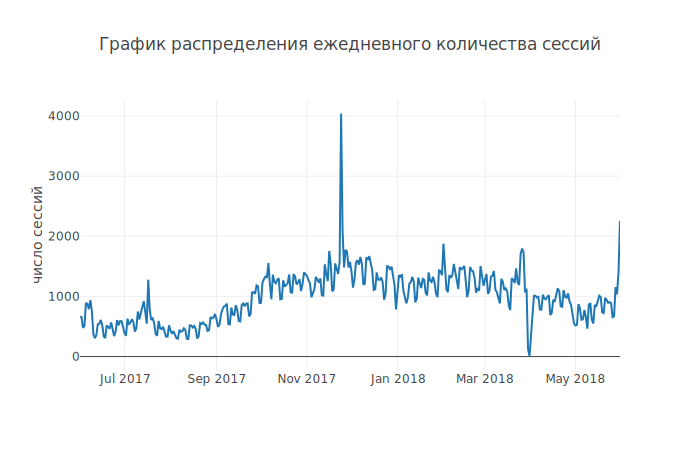

Среднее число сессий в день: 987


In [14]:
sessions = visits.groupby('day').agg({'start_ts': 'count'})
plotly_line(sessions.reset_index()['day'],
            sessions.reset_index()['start_ts'],'График распределения ежедневного количества сессий', mode='lines',
           ytitle='число сессий')
print('Среднее число сессий в день: {}'.format(int(sessions.mean())))

Больше всего сессий было 24 ноября - 4042.

### Сколько длится одна сессия?

Посчитаем среднюю и медианную продолжительности сессии:

In [15]:
visits['session_duration_min'] = ((visits['end_ts'] - visits['start_ts']).dt.seconds / 60).astype(int)
aslmean = visits['session_duration_min'].mean()
print()
print(f'Средняя продолжительность сессии составляет {int(aslmean * 60 // 60)} минут {int((aslmean * 60 % 60))} секунды')
aslmedian = visits['session_duration_min'].median()
print(f'Медианная продолжительность сессии составляет {int(aslmedian)} минут')


Средняя продолжительность сессии составляет 10 минут 43 секунды
Медианная продолжительность сессии составляет 5 минут


Среднее смещено в сторону максимума. Построим boxplot и посчитаем количество значений, превышающих размах:

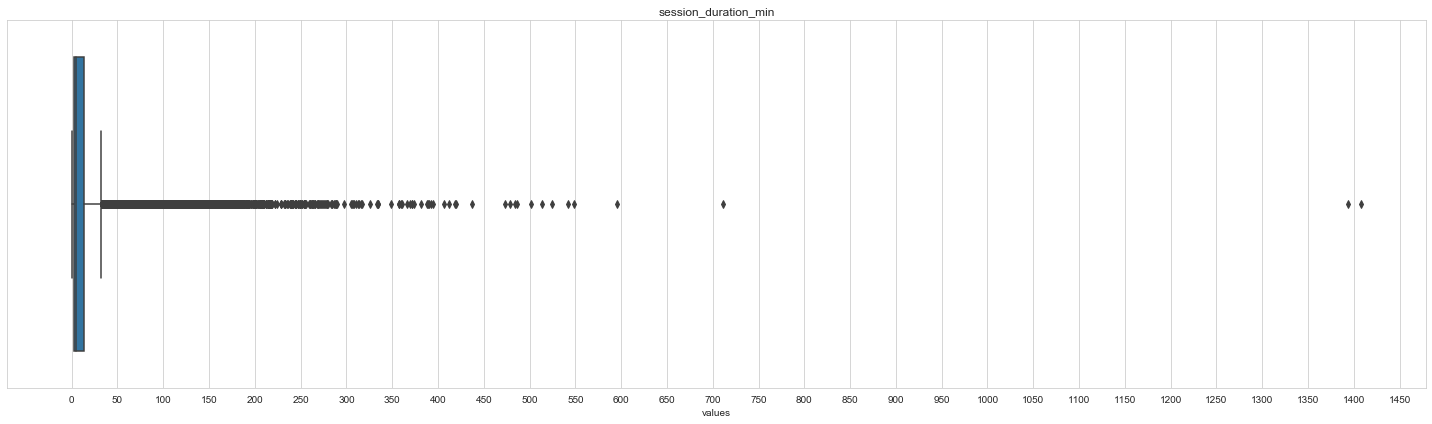

Количество сессий, превышающих размах boxplot: 17699, 4.92%


In [16]:
plt.figure(figsize=(20, 6))
sns.boxplot(visits['session_duration_min'],)
plt.title('session_duration_min')
plt.xlabel('values')
plt.tight_layout()
plt.xticks(range(0,1500, 50))
plt.show()

iqr = ((visits['session_duration_min'].quantile(0.75) + 
        visits['session_duration_min'].quantile(0.25)) * 1.5 + 
       visits['session_duration_min'].quantile(0.75))
print('Количество сессий, превышающих размах boxplot:', end=' ')
outburst = visits[visits['session_duration_min'] > iqr]['session_duration_min'].count()
print('{}, {:.2%}'.format(outburst, outburst / len(visits)))

Выбросов практически 5%, к тому же в аномалии попадают все значения начиная примерно с 35й минуты, это и объясняет, почему среднее так смещено.

Также исследуем, сессий какой продолжительности больше всего:

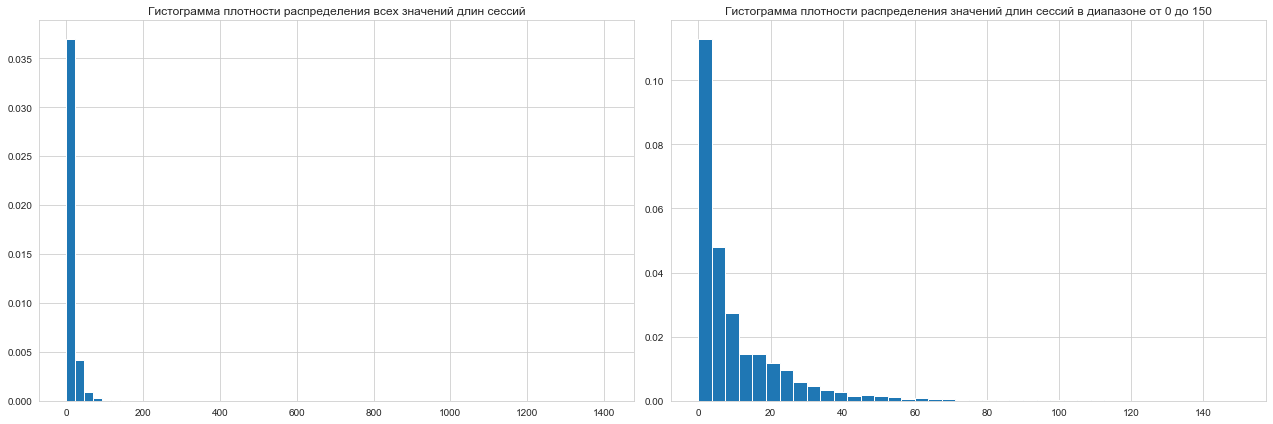


Чаще всего продолжительсность сессии составляет 60 секунд. Это 14.75% от всех записей в датасете


In [17]:
plt.subplots(figsize=(18,6))
plt.subplot(1,2,1)
plt.hist(visits['session_duration_min'], bins=60, density=True)
plt.title('Гистограмма плотности распределения всех значений длин сессий')
plt.subplot(1,2,2)
plt.hist(visits['session_duration_min'], bins=40, range=(0,150), density=True)
plt.title('Гистограмма плотности распределения значений длин сессий в диапазоне от 0 до 150')
plt.tight_layout()
plt.show()
session_lenght = st.mode(visits['session_duration_min'])
print()
print('Чаще всего продолжительсность сессии составляет {} секунд. Это {:.2%} от всех записей в датасете'.format(
    session_lenght[0][0]*60,session_lenght[1][0] / len(visits['session_duration_min'])))
    
    

### Изучение Retention Rate

Для того, чтобы ответить на вопрос, как часто пользователи возвращаются, проведем когортный анализ: выделим первую сессию в датафрейме visits для каждого пользователя. Из неё получим месяц первой сессии и сгруппируем эти данные с месяцем начала каждой сессии. На основе разницы во времени между месяцем начала сессии и месяцем первой сессии получим жизненный цикл когорты и построим сводную таблицу:

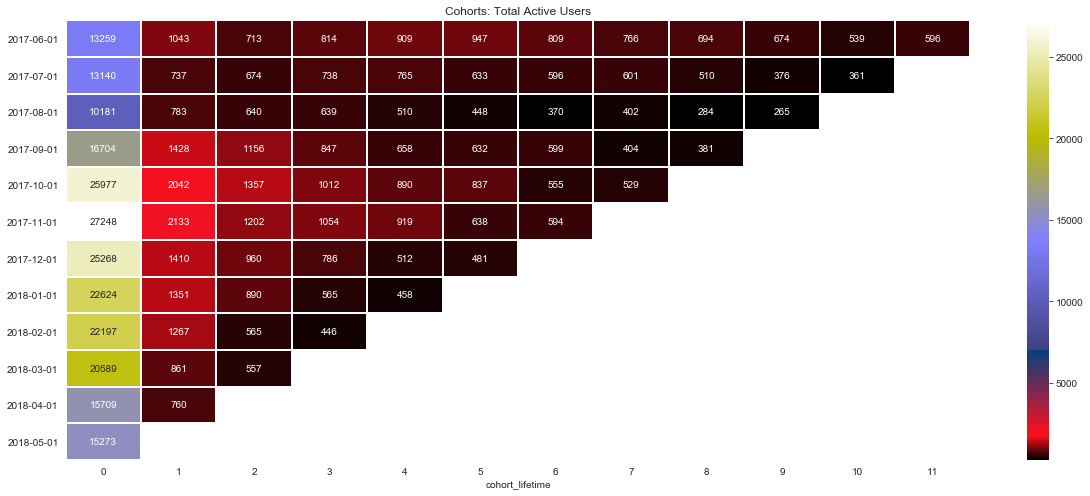

In [18]:
first_day_activity = (visits.groupby('uid').agg({'start_ts':'min'})
                      .rename(columns={'start_ts' : 'first_day_activity'}))
visits = (visits.join(first_day_activity, on='uid').assign(
    first_month_activity = lambda x: x['first_day_activity'].astype('datetime64[M]')))

grouped_users = (visits.groupby(['start_month_activity','first_month_activity'],as_index=False)
                 .agg({'uid':'nunique'}))
grouped_users['cohort_lifetime'] = (((grouped_users['start_month_activity']-grouped_users['first_month_activity'])
                                     / np.timedelta64(1,'M')).round().astype(int))
lifetime_pivot = (grouped_users.
                  pivot_table(index='first_month_activity', 
                              columns='cohort_lifetime', values='uid', aggfunc='sum'))
lifetime_pivot.index = lifetime_pivot.index.astype(str)

plt.subplots(figsize=(17,7))
ax = sns.heatmap(lifetime_pivot, annot=True, fmt='.0f', linewidths=1, 
            linecolor='white', cmap='gist_stern')
plt.title('Cohorts: Total Active Users')
ax.set_ylim(12,0)
plt.tight_layout()
plt.ylabel('')
plt.show()

На графике видно, что больше всего посещений в первый месяц в когортах с октября 2017 по март 2018, затем посещения резко падают. Посчитаем Retention Rate:

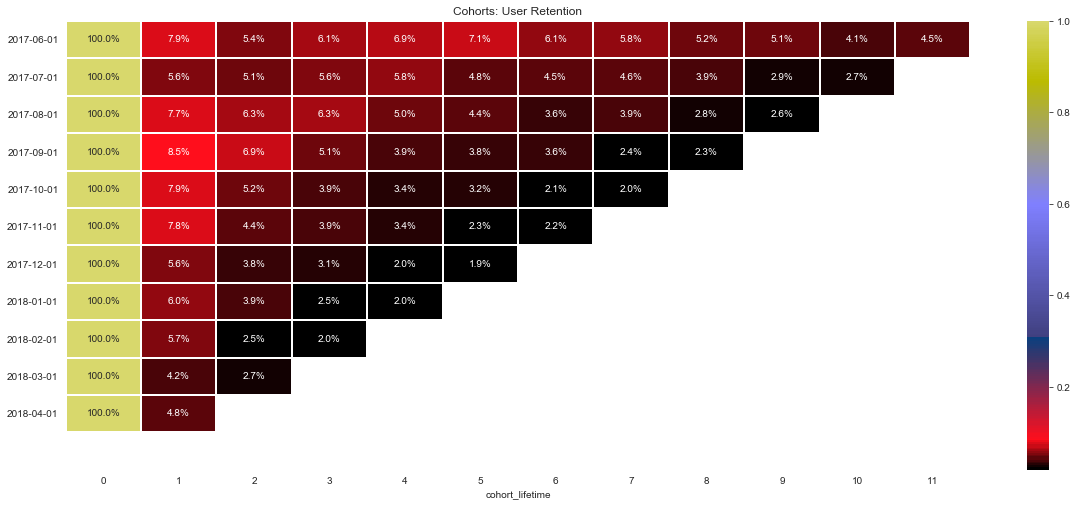

In [19]:
initial_users_count = (grouped_users[grouped_users['cohort_lifetime'] == 0][['first_month_activity','uid']]
                       .rename(columns={'uid':'fm_total'}))

grouped_users = (pd.merge(grouped_users, initial_users_count, on='first_month_activity')
                 .assign(retention = lambda x: x['uid'] / x['fm_total']))

retention_pivot = (grouped_users.pivot_table
                   (index='first_month_activity',columns='cohort_lifetime',
                    values='retention',aggfunc='sum'))
retention_pivot.index = retention_pivot.index.astype(str)
retention_pivot = retention_pivot.drop(['2018-05-01'])

plt.subplots(figsize=(17,7))
ax = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='white', cmap='gist_stern', 
                 center=0.6)
plt.tight_layout()
ax.set_ylim(12,0)
plt.title('Cohorts: User Retention')
plt.ylabel('')
plt.show()

Во всех когортах количество возвращающихся пользователей снижается уже на второй месяц на 90+%, в целом тенденция к снижению наблюдается по всему жизненному циклу когорт. Посмотрим средний Retention Rate на каждый месяц жизненного цикла для всех когорт:

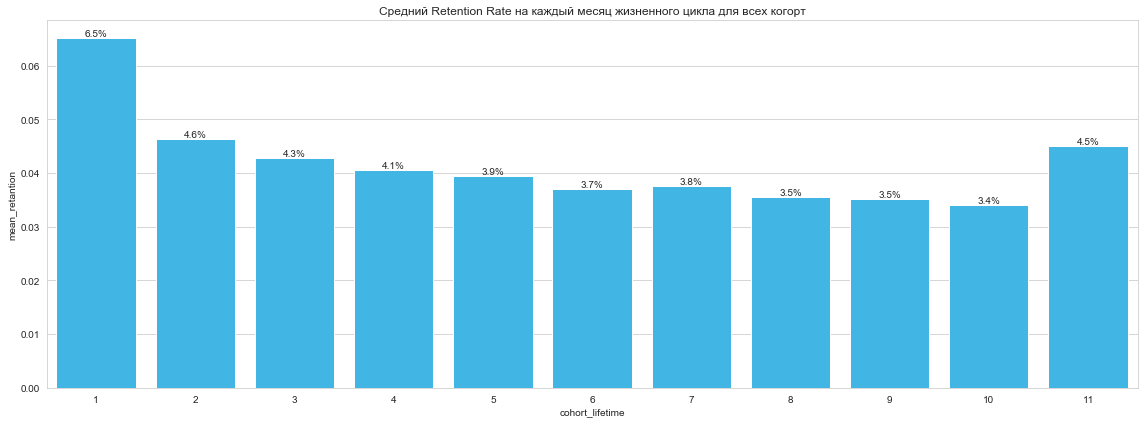

In [20]:
cohorts = grouped_users.groupby('cohort_lifetime',as_index=False)['retention'].mean().set_index('cohort_lifetime')
cohorts.columns = ['mean_retantion']
cohorts = cohorts.reset_index()
plt.figure(figsize=(16,6))
sns.barplot(data=cohorts.query('cohort_lifetime > 0'), x='cohort_lifetime', y='mean_retantion', 
            palette=['#26c2ff'])
for k,i in enumerate(cohorts.query('cohort_lifetime > 0')['mean_retantion']):
    plt.text(k, i, '{:.1%}'.format(i), ha='center', va='bottom')
plt.title('Cредний Retention Rate на каждый месяц жизненного цикла для всех когорт')
plt.tight_layout()
plt.show()

Средний Retention Rate продолжает снижаться каждый месяц, увелечение рейта в 11 месяце связано с тем, что до него дожила только первая когорта.

### Когда клиенты начинают покупать?

Для того, чтобы определить время первой покупки, посчитаем разницу между первой покупкой и первой сессией, данные получим в минутах:

In [21]:
purchase = (visits.groupby('uid').agg({'start_ts':'min'})
            .join(orders.groupby('uid').agg({'buy_ts':'min'}), on='uid', how='right'))
purchase['delta'] = (purchase['buy_ts'] - purchase['start_ts']).dt.seconds / 60
print(purchase['delta'].describe().astype(int).to_frame().to_markdown())

|       |   delta |
|:------|--------:|
| count |   36523 |
| mean  |     249 |
| std   |     429 |
| min   |       0 |
| 25%   |       4 |
| 50%   |      16 |
| 75%   |     252 |
| max   |    1439 |


И снова среднее сильно смещено в сторону максимума: среднее время первой покупки составляет 249 минут, тогда как медианное время 16 минут. Посмотрим, как значения распределились на гистограмме и посчитаем, какое время первой покупки встречается чаще всего:

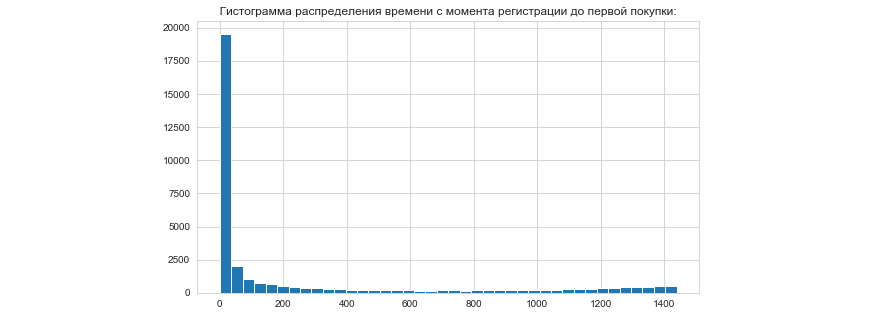

Чаще всего первая покупка происходит через 1.0 минуту после регистрации. Таких записей 7.31% в датасете


In [22]:
plt.figure(figsize=(9,5))
plt.hist(purchase[purchase['delta'] > 0]['delta'], bins=40)
plt.title(('Гистограмма распределения времени с момента регистрации до первой покупки:').center(200))
plt.show()
print('Чаще всего первая покупка происходит через {} минуту после регистрации. Таких записей {:.2%} в датасете'
      .format(purchase['delta'].mode()[0], 
              purchase['delta'].value_counts(normalize=True)[purchase['delta'].mode()[0]]))

### Сколько раз покупают за период?

Вычислим среднее число среднее число покупок и построим графики с количеством ежедневных и ежемесячных покупок:

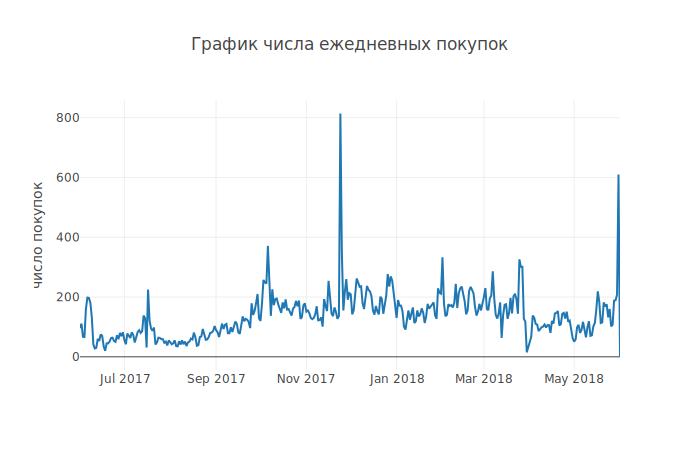

Среднее число покупок, совершаемых каждый день: 138.5


In [23]:
orders['day'] = orders['buy_ts'].dt.date
orders['month'] = orders['buy_ts'].astype('datetime64[M]')
daily = orders.groupby('day').agg({'uid':'count'})
meand_daily = daily.mean()[0].round(1)
plotly_line(daily.reset_index()['day'], daily.reset_index()['uid'], 'График числа ежедневных покупок', mode='lines',
           ytitle='число покупок')
print(f'Среднее число покупок, совершаемых каждый день: {meand_daily}')

Больше всего покупок было совершено 24 ноября 2017 года - 814, меньше всего первого июня 2018 - 1.

Среднее число покупок, совершаемых ежемесячно: 3878


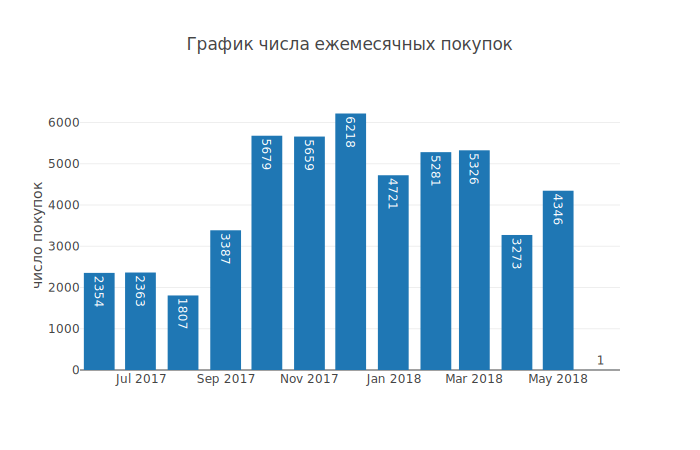

In [24]:
monthly = orders.groupby('month').agg({'uid':'count'})
print(f'Среднее число покупок, совершаемых ежемесячно: {int(monthly.mean()[0])}')
bar = go.Bar(x=monthly.reset_index()['month'], y=monthly.reset_index()['uid'], text=monthly.reset_index()['uid'],
        textposition='auto')
fig = go.Figure(bar)
fig.update_layout(template=None,title={'text':'График числа ежемесячных покупок'}, yaxis = {'title': 'число покупок'})
fig.show()

Больше всего покупок было совершено в декабре 2017 года - 6218.

### Изучение средниего чека и прибыли с покупателя (LTV)

Вычислим средний чек и, чтобы узнать, как он меняется во времени, проведем когортный анализ:

In [25]:
avbill = round(orders['revenue'].mean(),4)
print(f'Средний чек составляет: {avbill}')

Средний чек составляет: 4.9996


Посмотрим, как средний чек меняется с течением времени:

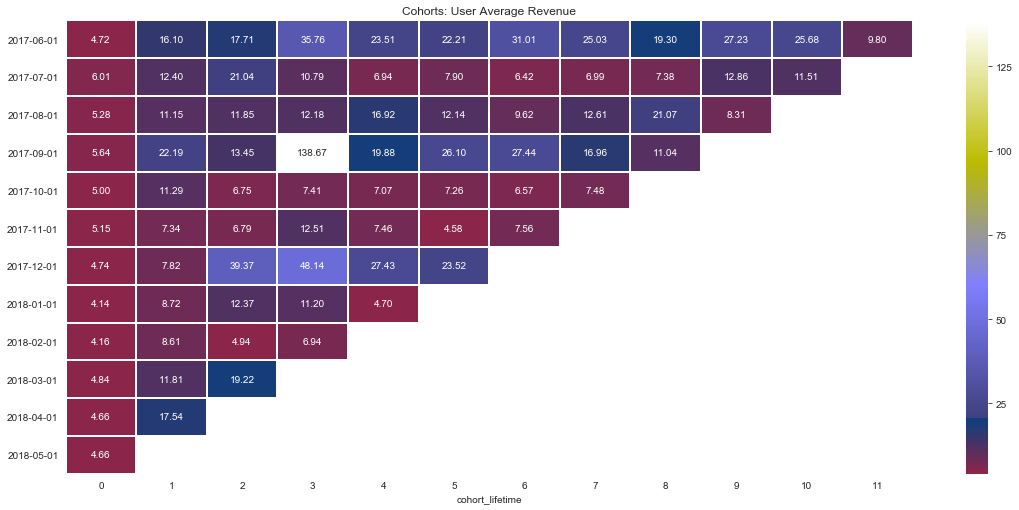

In [26]:
orders = (orders.join(orders.groupby('uid').agg({'buy_ts': 'min'})
                      .rename(columns = {'buy_ts':'first_buy_date'}), on='uid')
          .assign(buy_month = lambda x: x['buy_ts'].astype('datetime64[M]'),
                 first_buy_month = lambda x:  x['first_buy_date'].astype('datetime64[M]')))

revenue_group = (orders.groupby(['first_buy_month','buy_month'], as_index=False)
                 .agg({'revenue':'sum', 'uid': 'nunique'})
                 .assign(revenue_per_user = lambda x: x['revenue'] / x['uid'],
                         cohort_lifetime = lambda x: ((x['buy_month']-x['first_buy_month'])/np.timedelta64(1,'M'))
                        .round().astype(int)))
revenue_pivot = (
    revenue_group.pivot_table(index='first_buy_month', columns='cohort_lifetime', values='revenue_per_user',
                             aggfunc='mean')
)
revenue_pivot.index = revenue_pivot.index.astype(str)
revenue_pivot = revenue_pivot.drop(['2018-06-01'])

plt.subplots(figsize=(16,7))
ax = sns.heatmap(revenue_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap='gist_stern', 
                 center=60)
ax.set_ylim(12,0)
plt.tight_layout()
plt.title('Cohorts: User Average Revenue')
plt.ylabel('')
plt.show()

В целом можно отметить, что средний чек начинает расти со второго месяца во всех когортах, особенно он выделяется в июньской и сентябрьской: самый большой средний чек у сентябрьской когорты на четвером месяце жизни, составляет 138.67, в остальных когортах такой резкий подъем сложно зафиксировать. 

### Рассчет LTV

Чтобы ответить на этот вопрос, проведем когортный анализ и вычслим lifetime value для каждого пользователя:

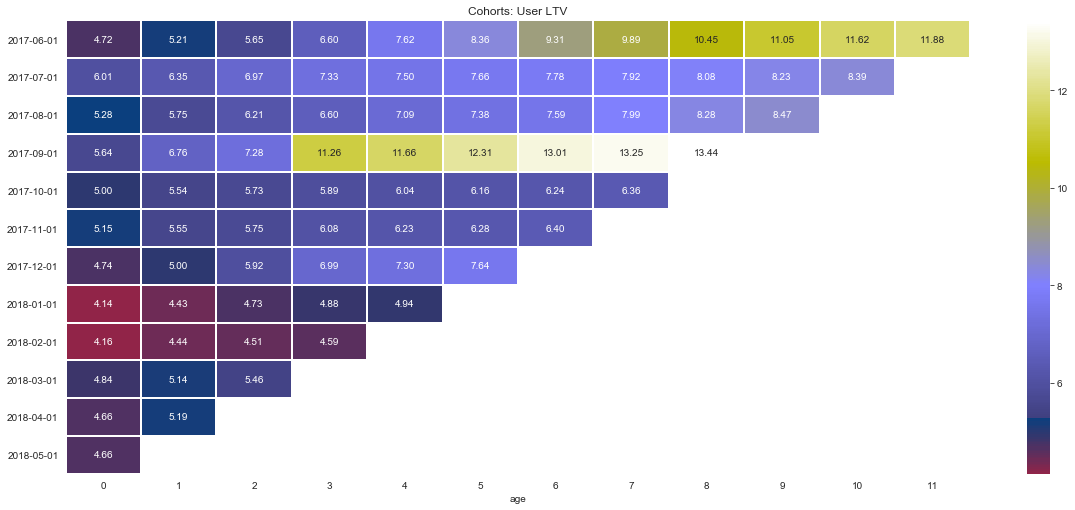

In [27]:
cohort_sizes = orders.groupby('first_buy_month').agg({'uid': 'nunique'}).rename(columns={'uid':'n_byers'})

report = (pd.merge(revenue_group, cohort_sizes, on='first_buy_month').rename(columns={'cohort_lifetime':'age'})
         .assign(ltv = lambda x: x['revenue'] / x['n_byers']))

#Когортная матрица
ltv_pivot = report.pivot_table(index='first_buy_month', columns='age', values='ltv', aggfunc='mean')
ltv_pivot.index = ltv_pivot.index.astype(str)
ltv_pivot = ltv_pivot.cumsum(axis = 1) 
ltv_pivot = ltv_pivot.drop(['2018-06-01'])
#график
plt.subplots(figsize=(17,7))
ax = sns.heatmap(ltv_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap='gist_stern', center=8)
ax.set_ylim(12,0)
plt.tight_layout()
plt.title('Cohorts: User LTV')
plt.ylabel('')
plt.show()

Больше всего денег приносит средний пользователь из сентябрьской когорт - 13.44, также высокие показатели у июньской когорты - 11.88. Вычислим средние LTV по каждому месяцу жизненного цикла:

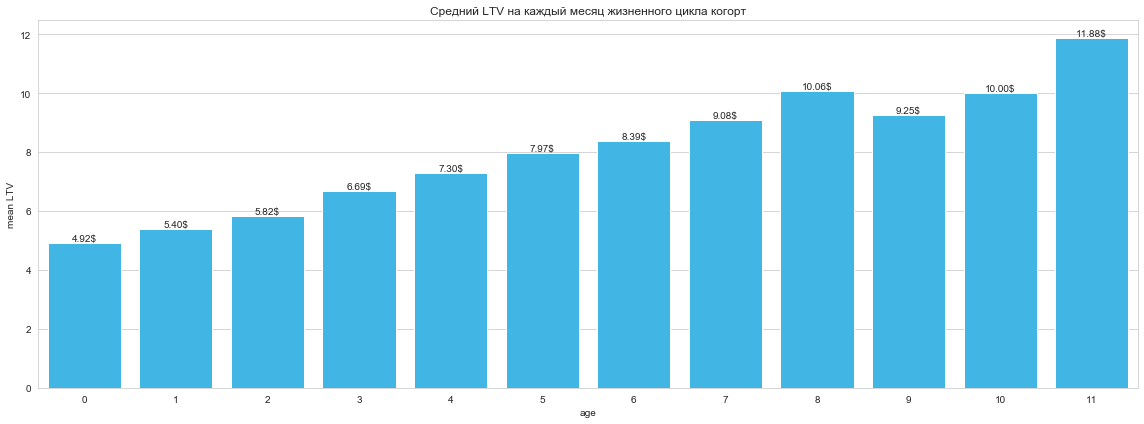

In [28]:
plt.figure(figsize=(16,6))
sns.barplot(data=ltv_pivot.mean().reset_index(), x='age', y=0, palette=['#26c2ff'])

plt.title('Средний LTV на каждый месяц жизненного цикла когорт')
plt.ylabel('mean LTV')
plt.tight_layout()
for k,i in enumerate(ltv_pivot.mean()):
    plt.text(k, i, '{:.2f}$'.format(i), ha='center', va='bottom')
plt.show()

Уже через полгода каждый средний пользователь будет приносить по 7.97$.

### Исследование затрат на привлечение покупателей (всего/на каждый источник/по времени)

Рассчитаем сумму, сгруппируем расходы по источникам и построим графики:

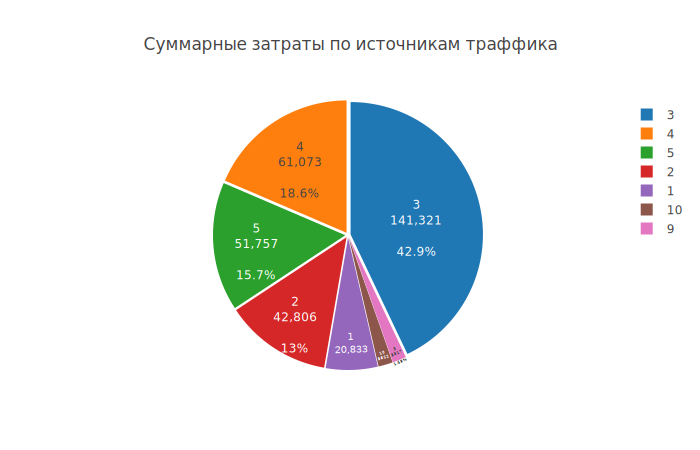

Всего потрачено денег на привлечение: 329131.62


In [29]:
sources_cost = costs.groupby('source_id').agg({'costs':'sum'}).reset_index().astype(int)

data = go.Pie(labels=sources_cost['source_id'], values=sources_cost['costs'], pull=0.02, 
              textposition='inside', textinfo='label+percent+value')
fig = go.Figure(data)
fig.update_layout(template=None,title={'text': 'Суммарные затраты по источникам траффика'})
fig.show()
print('Всего потрачено денег на привлечение:', costs['costs'].sum())

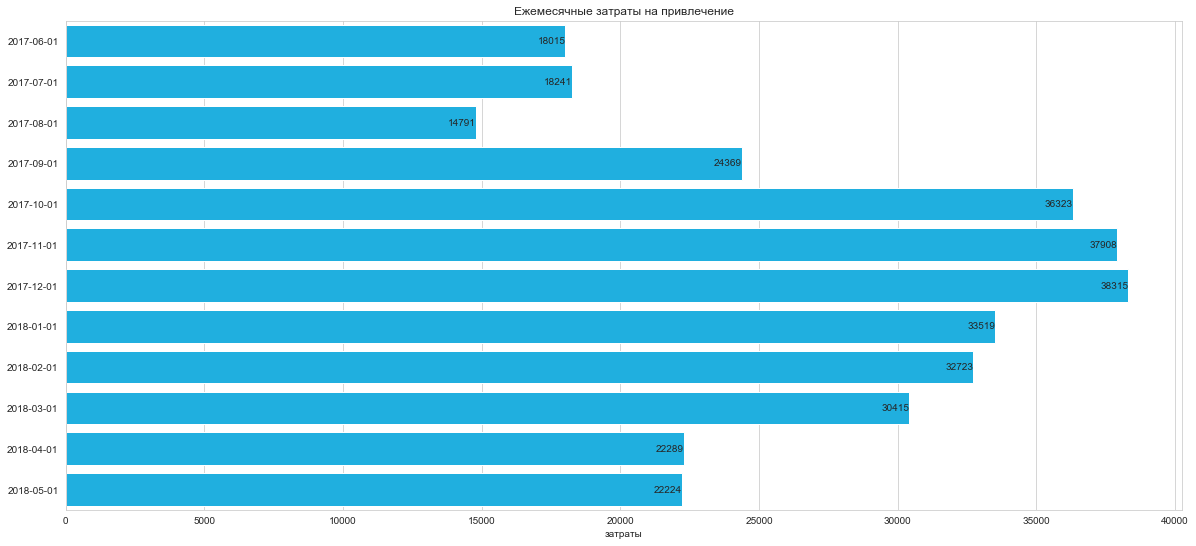

In [30]:
costs['month'] = costs['dt'].astype('datetime64[M]')
month_cost = costs.groupby('month').agg({'costs':'sum'})
month_cost = month_cost.reset_index()
month_cost['month'] = month_cost['month'].astype(str)
plt.subplots(figsize=(20, 9))
plt.title('Costs by Month')
sns.barplot(data=month_cost, y='month', x='costs', orient='h', color='deepskyblue')
for k,i in enumerate(month_cost['costs']):
    plt.text(i, k, '{:.0f}'.format(i), ha='right', va='center')
plt.title('Ежемесячные затраты на привлечение')
plt.xlabel('затраты')
plt.ylabel('')
plt.show()

Больше всего потрачено денег на привлечение пользователей через 3й источник - 141321, меньше всего через 9й и 10й - 5517 и 5822 соотвественно. По месяцам больше всего затрат пришлось с октября по декабрь 2017 года включительно - с 36322 по 38315, меньше всего на август 2017го - 14790.

### Исследование затрат на привлечение через источники

In [31]:
#сгруппируем пользователей по первой сессии, источнику и девайсу:
users = (visits.sort_values(by = ['uid', 'start_ts'])
               .groupby('uid')
               .agg({'start_ts' : 'first', 'source_id': 'first', 'device': 'first'})
               .rename(columns = {'start_ts' : 'acquisition_ts'}))
users['acquisition_date'] = users['acquisition_ts'].dt.date
users['acquisition_month'] = users['acquisition_ts'].astype('datetime64[M]') 
costs = costs.rename(columns={'dt': 'acquisition_date'})
#присоединим затраты из costs:
users = (users.reset_index()
              .set_index(['source_id', 'acquisition_date'])
              .join(costs.set_index(['source_id', 'acquisition_date']), how = 'left'))
#добавляем стоимость приобретения индивидуального пользователя
user_cost = (users.groupby(['source_id', 'acquisition_date'])
                  .agg({'device': 'count', 'costs': 'max'})
                  .rename(columns = {'device': 'users'}))
user_cost['acqusition_cost'] = user_cost['costs'] / user_cost['users']
users = users.join(user_cost[['acqusition_cost']], how = 'left').reset_index()
users = users.set_index('uid')[['acquisition_ts', 'acquisition_date', 'acquisition_month', 
                                'source_id', 'device', 'acqusition_cost']]

Рассчитаем затраты на привлечение для одного покупателя из каждого источника:

In [32]:
per_user = user_cost.reset_index().groupby(['source_id']).agg({'users':'sum', 'costs':'sum'})
per_user['cost_per_user'] = per_user['costs'] / per_user['users']
display(per_user.round(2))

,users,costs,cost_per_user
source_id,,,
1,9469,20833.27,2.20
2,17616,42806.04,2.43
3,66116,141321.63,2.14
4,72346,61073.60,0.84
5,49237,51756.40,1.05
6,2,0.00,0.00
7,32,0.00,0.00
9,6448,5454.42,0.85
10,6903,5821.12,0.84


Дороже всего обходится привлечение одного пользователя через 2й источник 2.43, дешевле всего через 10й - 0.84

### Исследование окупаемости расходов (ROI)

Чтобы ответить на этот вопрос, проведем когортный анализ:

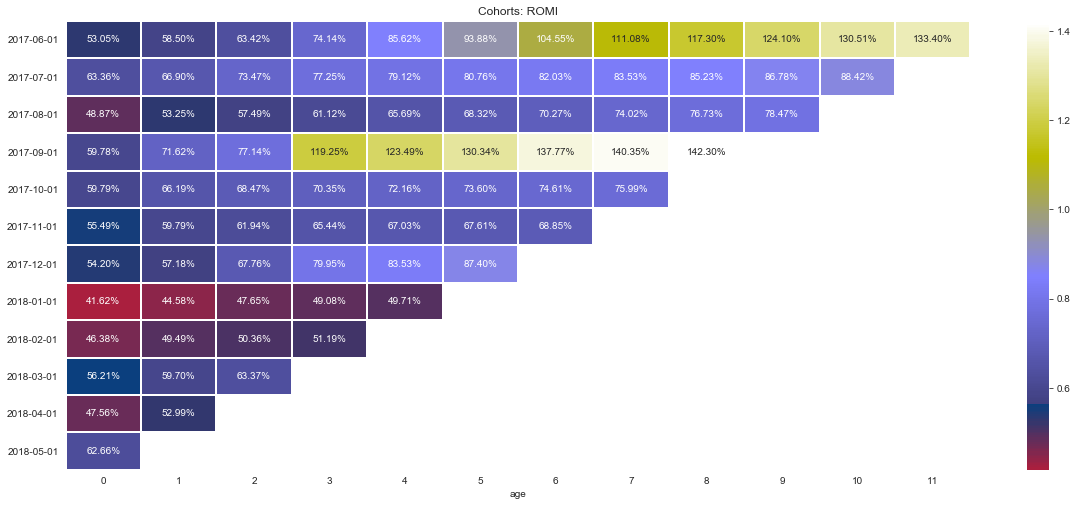

In [33]:
monthly_costs = costs.groupby('month', as_index=False).agg({'costs':'sum'})
report_new = report.merge(monthly_costs, left_on='first_buy_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_byers']
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
        index='first_buy_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')
output.index = output.index.astype(str)
plt.subplots(figsize=(17,7))
ax = sns.heatmap(output.cumsum(axis=1), annot=True, fmt='.2%', linewidths=1, linecolor='white', cmap='gist_stern',
                center=0.85)
plt.tight_layout()
ax.set_ylim(12,0)
plt.ylabel('')
plt.title('Cohorts: ROMI')
plt.show()

На графике видно, что пользователи из июньской когорты окупились уже через 7 месяцев, а из сентябрьской даже на 4й месяц. Остальные когороты так и не окупились. Наименьшие показатели по окупаемости у январской когорты.

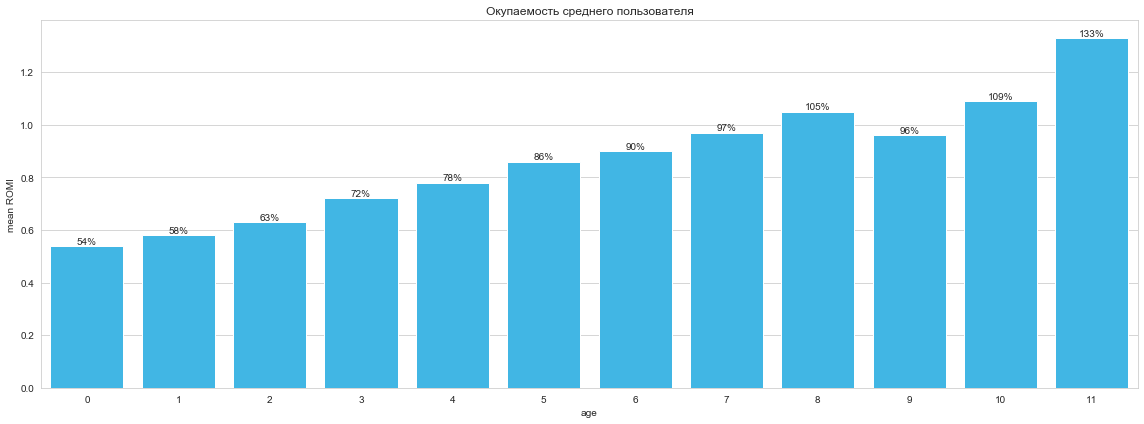

In [34]:
payback = output.cumsum(axis=1).mean().round(2).reset_index()
plt.figure(figsize=(16,6))
sns.barplot(data=payback, x='age', y=0, palette=['#26c2ff'])
for k,i in enumerate(payback[0]):
    plt.text(k, i, '{:.0%}'.format(i), ha='center', va='bottom')
plt.ylabel('mean ROMI')
plt.title('Окупаемость среднего пользователя')
plt.tight_layout()
plt.show()

Средний пользователь начинает окупаться с 9го месяца.

### Отобразим на графиках, как эти метрики отличаются по устройствам и по рекламным источникам, как они меняются во времени

Для того, чтобы в выборку попали пользователи, дожившие до 7го месяца, исключим тех, кто пришел после 2017-12-01. 6 и 7й источник будем исключать из таблиц, поскольку данных по ним недостаточно, а также затраты на привлечение по ним отсуствуют. Изучим удержание по источникам и устройствам:

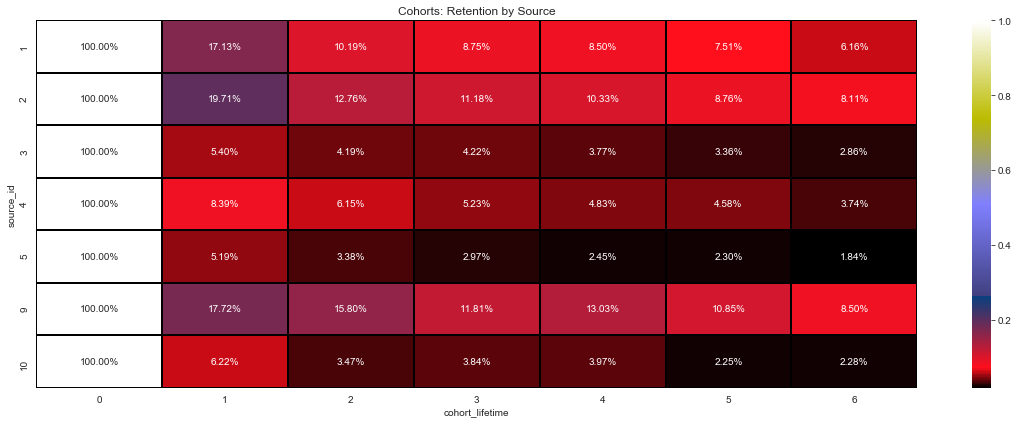

In [35]:
visits['cohort_lifetime'] = ((visits['start_month_activity'] - visits['first_month_activity']) 
                             / np.timedelta64(1,'M')).round().astype(int)

source_cohorts = (visits[visits['first_month_activity'] < '2017-12-01'].groupby
                  (['source_id', 'cohort_lifetime'], as_index=False).agg({'uid':'nunique'})
                 )
in_count = source_cohorts[source_cohorts['cohort_lifetime'] == 0][['source_id', 'uid']]
in_count = in_count.rename(columns={'uid':'cohort_users'})
source_cohorts = source_cohorts.merge(in_count, on='source_id')
source_cohorts['retention'] = source_cohorts['uid'] / source_cohorts['cohort_users']
retention_source_pivot = (source_cohorts[source_cohorts['cohort_lifetime'] < 7].pivot_table
                          (index='source_id', columns='cohort_lifetime', 
                           values='retention', aggfunc='sum')
                         )
retention_source_pivot = retention_source_pivot.drop([6])
retention_source_pivot = retention_source_pivot.drop([7])
plt.subplots(figsize=(16,6))
ax = sns.heatmap(retention_source_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='black',cmap='gist_stern',
               center=0.51)
plt.title('Cohorts: Retention by Source')
ax.set_ylim(7,0)
plt.tight_layout()
plt.show()

Ко второму месяцу Retention Rate резко падает в когортах по всем источникам - ~80%, затем продолжает снижаться к 7му месяцу. Ко второму месяцу самое высокое удержание во втором источнике - 19.71%, к седьмому самое высокое удержание у пользователей, которые пришли через 9й источник - 8.50%. Самое низкое удержание у 5го источника - 1.84%

Построим таблицу по устройствам:

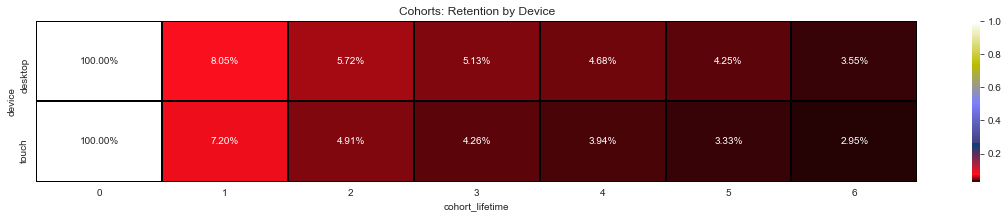

In [36]:
device_cohorts = (visits[visits['first_month_activity'] < '2017-12-01'].groupby
                  (['device', 'cohort_lifetime'], as_index=False).agg({'uid':'nunique'}))
in_count_d = (device_cohorts[device_cohorts['cohort_lifetime'] == 0][['device', 'uid']]
              .rename(columns={'uid':'cohort_users'}))

device_cohorts = device_cohorts.merge(in_count_d, on='device').assign(
    retention = lambda x: x['uid'] / x['cohort_users'])

retention_device_pivot = (device_cohorts[device_cohorts['cohort_lifetime'] < 7].pivot_table
                          (index='device', columns='cohort_lifetime', 
                           values='retention', aggfunc='sum')
                         )
plt.subplots(figsize=(16,3))
ax = sns.heatmap(retention_device_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='black', 
                 cmap='gist_stern', center=0.51)
plt.tight_layout()
plt.title('Cohorts: Retention by Device')
ax.set_ylim(2,0)
plt.show()

Удержание по девайсам имеет практически одинаковые коэффициенты и тенденцию к снижению. В целом у desktop показатели немного выше, 3.55% к 7му месяцу, против 2.95% у touch.

Изучим LTV по источникам и LTV по устройствам:

In [37]:
mergewithord = visits[['uid','source_id', 'day', 'device']]
orders_new = (orders.merge(mergewithord, on=['uid','day'], how='inner').assign(
    cohort_lifetime = lambda x:((x['buy_month']-x['first_buy_month'])/np.timedelta64(1,'M')).round().astype(int)))

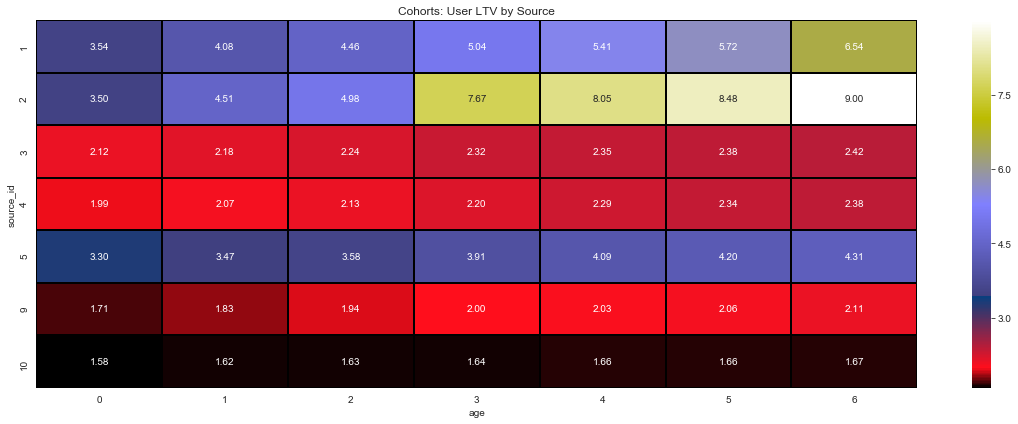

In [38]:
revenue_source = (orders_new[orders_new['first_buy_month'] < '2017-12-01'].groupby(
    ['source_id', 'cohort_lifetime'], as_index=False)
                  .agg({'revenue':'sum','uid':'nunique'})
                 )
source_sizes = orders_new.groupby('source_id').agg({'uid': 'nunique'}).rename(columns={'uid':'n_byers'})
source_report = pd.merge(revenue_source, source_sizes, on='source_id').rename(columns={'cohort_lifetime':'age'})
source_report['ltv'] = source_report['revenue'] / source_report['n_byers']

source_ltv_pivot = source_report[source_report['age'] < 7].pivot_table(
    index='source_id', columns='age', values='ltv', aggfunc='mean')
source_ltv_pivot = source_ltv_pivot.cumsum(axis = 1) 
source_ltv_pivot = source_ltv_pivot.drop([7])

plt.subplots(figsize=(16,6))
ax = sns.heatmap(source_ltv_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='black', 
                 cmap='gist_stern')
plt.title('Cohorts: User LTV by Source')
plt.tight_layout()
ax.set_ylim(7, 0)
plt.show()

Больше всего денег приносят пользователи, привлеченнные через второй источник - к 7му месяцу LTV = 9, чуть меньше через первый - 6.54, пятый источник на третьем месте по LTV - 4.31. Меньше всех денег приносят пользователи, привлеченные через 10й источник, LTV = 1.67. 

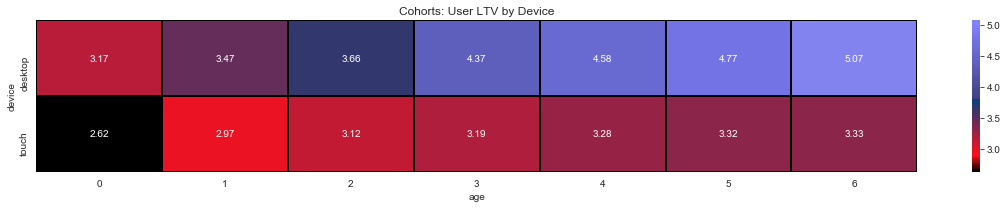

In [39]:
revenue_device = (orders_new[orders_new['first_buy_month'] < '2017-12-01']
                  .groupby(['device', 'cohort_lifetime'], as_index=False)
                  .agg({'revenue':'sum','uid':'nunique'}))

device_sizes = orders_new.groupby('device').agg({'uid': 'nunique'}).rename(columns={'uid':'n_byers'})
device_report = pd.merge(revenue_device, device_sizes, on='device').rename(columns={'cohort_lifetime':'age'})
device_report['ltv'] = device_report['revenue'] / device_report['n_byers']

device_ltv_pivot = device_report[device_report['age'] < 7].pivot_table(index='device', columns='age', 
                                                                       values='ltv', aggfunc='mean')
device_ltv_pivot = device_ltv_pivot.cumsum(axis=1) 
plt.subplots(figsize=(16,3))
ax = sns.heatmap(device_ltv_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='black', cmap='gist_stern',
                center=5)
plt.title('Cohorts: User LTV by Device')
ax.set_ylim(2,0)
plt.tight_layout()
plt.show()

Больше всего LTV приносят пользователи desktop - 5.07 на 7й месяй, touch всего 3.33.

Изучим ROMI по источникам и ROMI по устройствам:

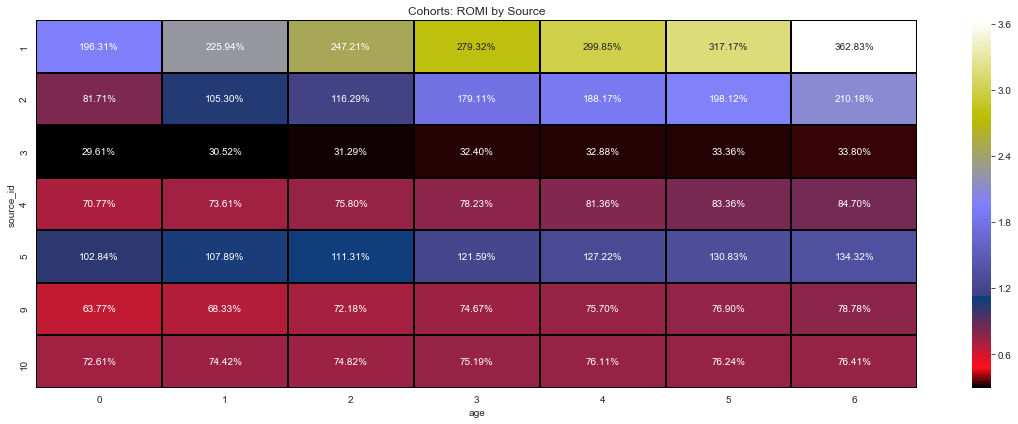

In [40]:
costs_by_source = costs[costs['month'] < '2017-12-01'].groupby('source_id', as_index=False).agg({'costs':'sum'})
source_report_new = source_report.merge(costs_by_source, on='source_id').assign(
                    cac = lambda x: x['costs'] / x['n_byers'],
                    romi = lambda x: x['ltv'] / x['cac'])
output_source = source_report_new[source_report_new['age'] < 7].pivot_table(
        index='source_id', 
        columns='age', 
        values='romi', 
        aggfunc='mean')
plt.subplots(figsize=(16,6))
ax = sns.heatmap(output_source.cumsum(axis=1), annot=True, fmt='.2%', linewidths=1, linecolor='black',
                cmap='gist_stern')
plt.title('Cohorts: ROMI by Source')
plt.tight_layout()
ax.set_ylim(7,0)
plt.show()

Наилучшую окупаемость показывает первый источник - в первый же месяц он окупается почти в два раза, а на 7й больее чем в 3.5 раза. Также высокая окупаемость у второго истончика, он начинает окупаться со второго месяца, а к 7 окупается более чем в 2 раза. 5й источник окупается с первого месяца по 7й. Остальные источники не окупаются - у 3го самая низкая окупаемость, всего лишь 33%.

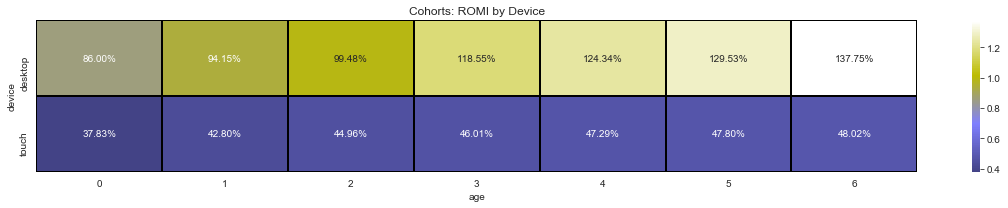

In [41]:
cost_by_device = (users[users['acquisition_month'] > '2017-12-01']
                  .groupby('device', as_index=False).agg({'acqusition_cost': 'sum'}))

device_report_new = device_report.merge(cost_by_device, on='device').assign(
                    cac = lambda x: x['acqusition_cost'] / x['n_byers'],
                    romi = lambda x: x['ltv'] / x['cac'])

output_device = device_report_new[device_report_new['age'] < 7].pivot_table(
        index='device', 
        columns='age', 
        values='romi', 
        aggfunc='mean')
plt.subplots(figsize=(16,3))
ax = sns.heatmap(output_device.cumsum(axis=1), annot=True, fmt='.2%', linewidths=1, linecolor='black',
                cmap = 'gist_stern', center=0.7)
plt.title('Cohorts: ROMI by Device')
ax.set_ylim(2,0)
plt.tight_layout()
plt.show()

Пользователи desktop начинают окупаться на 4й месяц, к 7му приносят 37% прибыли. Пользователи touch не окупаются за этот период.

### Вывод

- Среднее число уникальных пользователей в день: 907
- Среднее число уникальных пользователей в неделю: 5825
- Среднее число уникальных пользователей в месяц: 23228
- Среднее число сессий в день: 987
- Медианная продолжительность сессии составляет 5 минут
- Во всех когортах количество возвращающихся пользователей снижается уже на второй месяц на 90+%, в целом тенденция к снижению наблюдается по всему жизненному циклу когорт
- Медианное время первой покупки составляет 16 минут 
- Среднее число покупок, совершаемых каждый день: 138.5
- Средний чек составляет: 4.9996
- Больше всего денег приносит средний пользователь из сентябрьской когорты - 13.44, также высокие показатели у июньской когорты - 11.88
- Всего потрачено денег на привлечение пользоватей: 329131.62
- Дороже всего обходится привлечение одного пользователя через 2й источник - 2.43, дешевле всего через 10й - 0.84
- Средний пользователь начинает окупаться с 9го месяца

## 3. Рекомендация:

Я рекомендую маркетологам сделать упор на первый и второй источники, а также на платформу desktop, поскольку у них наиболее высокие:
- Retention Rate к 7му месяцу - 6.16% и 8.11%, у desktop - 3.55%.
- LTV во втором источнике к 7му месяцу - 9, в первом - 6.54, 5.07 у desktop.
- ROMI у первого источника почти 200% в первый месяц, а на 7й больее чем 360%. Второй источник окупается со второго месяца, а на 7й окупается более чем в 2 раза. Desktop окупается с 4го месяца: ROMI 118%

Тем не менее, через первый и второй источники приходит всего 27k пользователей, в то время как в 5м - 50k, поэтому также предлагаю сделать упор на него. 5й источник показывает неплохую окупаемость с первого месяца по 7й - 102%-134% и LTV = 4.31, тем не менее Retention Rate к 7му месяцу падает до 1.84%. Вероятно для этих пользователей стоит оптимизировать стратегию удержания.

Выделять деньги на привлечение можно из расчета стоимости на привлечение одного пользователя через каждый источник: 2.20 на первый, 2.43 на второй и 1.05 на 5й.

Остальные источники не окупаются. При этом, я бы рекомендовал оптимизировать стратегию и расходы для 3го и 4го источника, - окупаемость для 3го всего 33% к 7му месяцу, для 4го 84%, но через них приходит больше всего пользователей: 66k и 72k. Расходы на 4й источник в 2+ раза меньше, чем на 3й - 61k против 141k.